# Make bar plots of ROH tracts
Make admixture style plots of ROH, both expected as well as for empirical Individuals

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./package/") # Append Hapsburg Folder
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh

midway2-0405.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Calculate some expectations

In [2]:
def create_cousins_roh(degrees=[1,2,3], 
                       bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    c_roh = np.zeros((len(degrees),len(bins))) # Container for results Cousins
    for i,c in enumerate(degrees):
        for j,b in enumerate(bins):
            m = c*2 + 4
            c_roh[i,j] = e_roh.exp_roh_len_in_bin_rel(l=b, m=m, comm_anc=4, bins=10000)
    return c_roh

#bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]  # The bins I want to plot (eventually maybe do 12,16 as welll)
#cousins = [1, 2, 3]  # Which Cousins to Plot

def create_Ne_roh(Ns=[400, 800, 1600, 3200, 6400], 
                  bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for panmictic population sizes
    Ns: List of population sizes
    bins: Length Bins (in Morgan) to calculate expectations from
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    n_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            n_roh[i,j] = e_roh.exp_roh_len_in_bin_N(b, N=N, bins=bin_n)
    return n_roh

def std_Ne_roh(Ns=[400, 800, 1600, 3200, 6400], 
                  bins=[[0.04,0.08],[0.08,0.12],[0.12,0.2],[0.2,3.0]], bin_n=10000):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for panmictic population sizes
    Ns: List of population sizes
    bins: Length Bins (in Morgan) to calculate expectations from
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    var_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            var_roh[i,j] = e_roh.var_roh_len_in_bin_N(b, N=N, bins=bin_n)
    return np.sqrt(var_roh)  # Return Standard Deviation

# Code for the Main Figure

### Idea:
Code should be very modular: The large figure uses gridspec to split 
up axis space, and on each axis I plot the bars, with legends / colors for populations below
(and maybe small age inlets).

The big code splits up the space according to sample Nr. The small axis do the plotting

### Do a subfigure

In [10]:
def plot_bar_ax(ax, fracs, bins=[], c=["#313695", "#abd9e9", "#fee090", "#d7191c"], x_ticks = [], 
                ec = "silver", fs_l=10, fs = 10, fs_x=8, barWidth=0.95, ylim = [0,220], stds = [], title="", 
                yticks=False, legend=False, r_title=0, hlines=[], ylabel="Sum Inferred ROH>4cM [cM]"):
    """Plot bars of ROH on Axis.
    ax: Where to Plot on
    fracs: Fractions of Expected ROH: [n Inds, n Bins]
    c: Which colors to plot
    bins: List of Bins (needed for legend - plotted if len()>0)
    yticks: Whether to plot Y tick Labels
    legend: Whether to plot Legend
    fs_x: Fontsize on the x Labels
    r_title: Rotation of the title
    hlines: List where to plot hlines"""
    y = fracs ### Fractions (along 1st axis length classes)
    x = np.arange(len(y))

    for i in range(len(y[0,:])): # From last to first (For Legend)
        b = np.sum(y[:,:i], axis=1)
        ax.bar(x, y[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=f"{bins[i,0]}-{bins[i,1]} cM", alpha=0.9)
        if len(stds)>0 and i>0: # Plot some standard deviations.
            ax1.errorbar(r, b, yerr=stds[:,i], fmt='none', linewidth=2, color="k")
    
    if len(hlines)>0:
        for y in hlines:
            ax.axhline(y=y, zorder=0, linestyle="--", color="gray", lw=0.5)     
    
    if legend:
        ax.legend(fontsize=fs_l, loc="upper right", title="Sum ROH in")
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_ylim(ylim)
    ax.set_xlim(x[0] - 0.7*barWidth, x[-1] + 0.7*barWidth)
    if len(x_ticks)>0:
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticks, fontsize=fs_x, rotation=270)
    else:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    if len(title)>0:
        ax.set_title(title, fontsize=fs, rotation=r_title)
        
        
def plot_panel_row(plot_dfs, wspace=0.05, hspace=0.01, figsize=(24,3.5), savepath="", x_ticks=True,
                   c=["#313695", "#abd9e9", "#fee090", "#d7191c"], ylim = [0,250], r_title = 90, 
                   leg_pos = -2, show=True, title_col="clst", legends=True, hlines=[],
                   bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2, 3.0]],
                   degrees=[1, 2, 3], Ns=[400, 800, 1600, 3200, 6400]):
    """Plot row of ROH bin plots from plot_dfs (each df one panel)
    leg_pos = Where to plot legend (if outside range no legend plot)
    r_title: How much to rotate the title
    gs: Gridspec: If given plot on there.
    legends: Whether to plot the two legends
    hlines: Where to plot horizontal lines
    bins: list of length bins to plot [[a1,a2],...[z1,z2]]
    Ns: What population sizes to plot in barplot [list]
    degrees: What degrees of Cousins to plot. [list]"""
    bins_cM=(np.array(bins)*100).astype("int")
    n_plots = len(plot_dfs)
    width_ratios = [len(df) for df in plot_dfs]
    if legends:     
        n_plots+= 2
        width_ratios+=[len(degrees), len(Ns)]
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, n_plots, width_ratios=width_ratios, figure=fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for i,df in enumerate(plot_dfs):   
        if i==0:
            ytick=True
        else:
            ytick=False

        if i == (len(plot_dfs) + leg_pos):
            legend=True
        else:
            legend=False

        ax = plt.subplot(gs[i])    # Extract the Sub Plot to Plot onto
        obs_roh = df[cols].values
        
        ### Calculate the value in the Bins
        for i in range(len(cols)-1):
            obs_roh[:,i] = obs_roh[:,i] - obs_roh[:,i+1]
        
        if x_ticks:
            x_ticks0 = df["iid"].values
        else: 
            x_ticks0 = []
        plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title, c=c,
                    x_ticks = x_ticks0, title=df[title_col].values[0], ylim=ylim, hlines=hlines)

    #### Plot the legend bars
    if legends:
        ### 0) Calculate Expectations
        c_roh = create_cousins_roh(degrees = degrees, bins = bins)
        sum_roh = create_Ne_roh(Ns=Ns, bins = bins)
        
        ### 1) Small Pops
        ax = plt.subplot(gs[-2])    # The left subplot (Timeline)
        plot_bar_ax(ax, c_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim, c=c, hlines=hlines,
                   x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops", r_title=r_title)
        ### 2) Cousins
        ax = plt.subplot(gs[-1])
        ticks_N = [f"2N={i}" for i in Ns]
        plot_bar_ax(ax, sum_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim, c=c,
                    hlines=hlines, x_ticks = ticks_N, title="Small Pop. Size", r_title=r_title)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
        
    if show:
        plt.show()
    return
    
    
def plot_legend_only(figsize=(7,6), wspace=0.05, hspace=0.01, savepath="",
                     fs=12, fs_l=10, fs_x=10, c=["#313695", "#abd9e9", "#fee090", "#d7191c"],
                     bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2,3.0]],
                     degrees=[1, 2, 3], Ns=[400, 800, 1600, 3200, 6400]
                     ):
    """Plot Inbreeding from recent Cousins as well as small pop size.
    bins: list of length bins to plot [[a1,a2],...[z1,z2]]
    Ns: What population sizes to plot in barplot [list]
    degrees: What degrees of Cousins to plot. [list]"""
    width_ratios = [len(degrees), len(Ns)]
    bins_cM=(np.array(bins)*100).astype("int")
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios, figure=fig)
    ax_cousin = plt.subplot(gs[0])    # The left subplot (Timeline)
    ax_Ne = plt.subplot(gs[1])
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ### Calcualte Expectations Cousins:
    c_roh = create_cousins_roh(degrees = degrees, bins = bins)
    
    ### Calculate Expectations Ne:
    sum_roh = create_Ne_roh(Ns=Ns, bins = bins)
    
    plot_bar_ax(ax_cousin, c_roh*100, bins_cM, yticks=True, legend=False, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, c=c, ylabel="Expected Sum ROH>4cM [cM]",
                x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops")

    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax_Ne, sum_roh*100, bins_cM, yticks=False, legend=True, c=c, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, x_ticks = ticks_N, 
                title="Small Pop. Size")
            
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}") 
    plt.show()
    
    
def prepare_dfs_plot(df, cms=[4,8,12], col_group="clst", split_modern=True,
                     mod_group="pop", sortcol=0):
    """Prepare the Dataframe which to plot
    Return split up (and sorted) list of df, return list of column names
    df: Master Dataframe
    cms: Minimum Length of Chromosomes in bins
    sortcol: By which > column to sort within group [int]
    if split_modern, split age==0 samples by mod_group
    """
    
    if split_modern:
        mod_idx = df["age"]==0  # Pull out modern idx
        df.loc[mod_idx, col_group]=df.loc[mod_idx, mod_group]
        
    plot_dfs = [dft for _, dft in df.groupby(col_group)]
    ### Sort by age
    idx = np.argsort([-df["age"].values[0] for df in plot_dfs])
    plot_dfs = [plot_dfs[i] for i in idx] ## Sort
    
    ### Split up blocks and sort by lowest
    cols = [f"sum_roh>{cm}" for cm in cms]
    for df in plot_dfs:
        df.sort_values(by=cols[sortcol], inplace=True, ascending=False)
    return plot_dfs, cols

### Single Example for theoretical Expectations [For Supplement]

Saved figure to ./figures/manuscript/supplement/bar_expectations.pdf


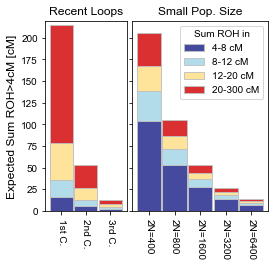

In [6]:
plot_legend_only(savepath="./figures/manuscript/supplement/bar_expectations.pdf", figsize=(4,3.5), 
                 c=["#313695", "#abd9e9", "#fee090", "#d7191c"])

## Do the Plot for empirical data

### Roman Data Row

Saved figure to ./figures/roman_pilot.png


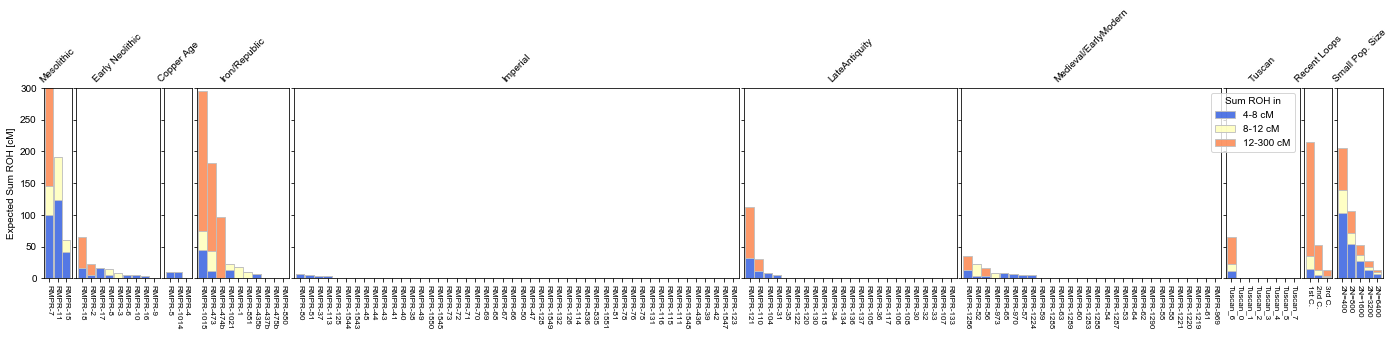

In [10]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Rome"]
plot_dfs, cols = prepare_dfs_plot(df1)

plot_panel_row(plot_dfs, savepath="./figures/roman_pilot.png", 
               wspace=0.035, r_title=45, leg_pos=-1, ylim=[0,300])

## Iberia transect Row

Saved figure to ./figures/iberia_pilot.pdf


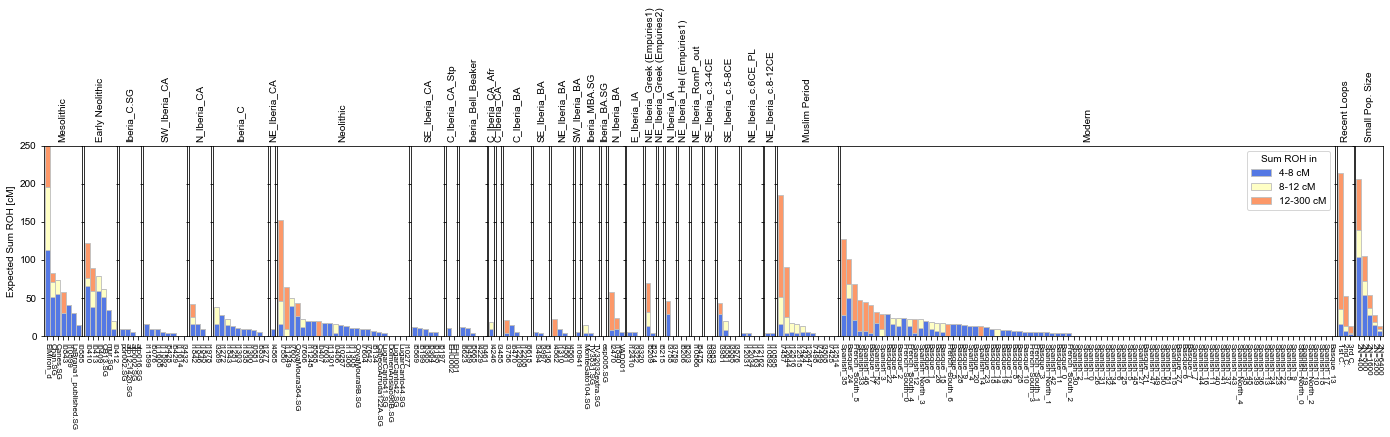

In [11]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Iberia"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures/iberia_pilot.pdf", leg_pos=-1)

### Balkans

Saved figure to ./figures_test/balkans.pdf


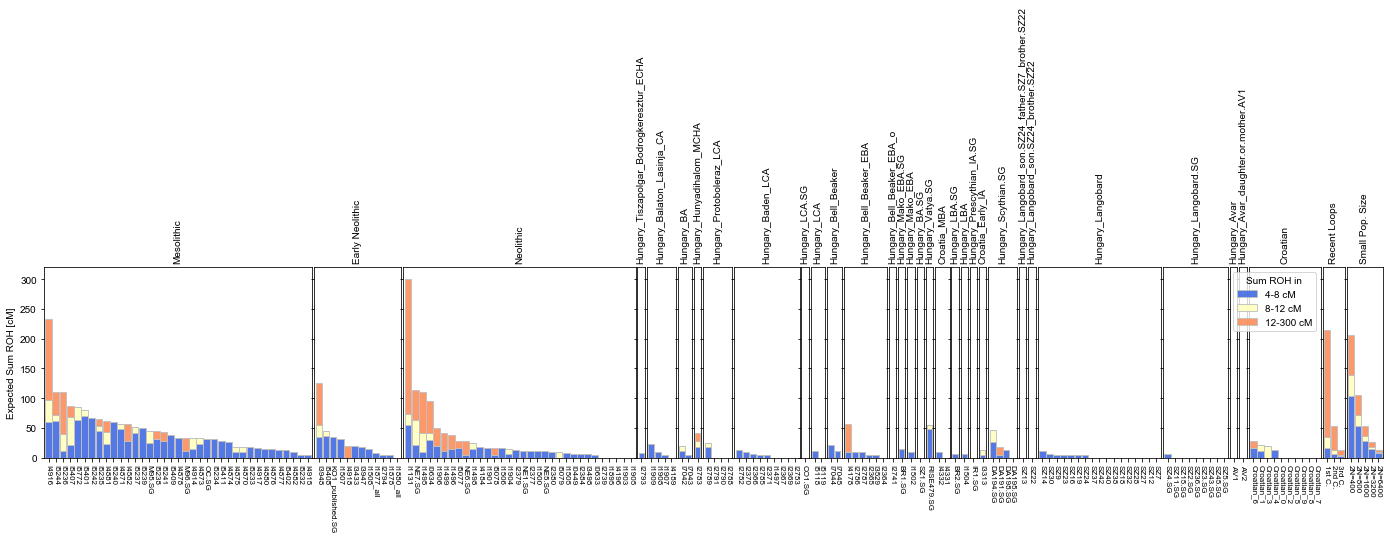

In [30]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Balkans"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures_test/balkans.pdf", leg_pos=-1, ylim=[0, 320])

### Aegan

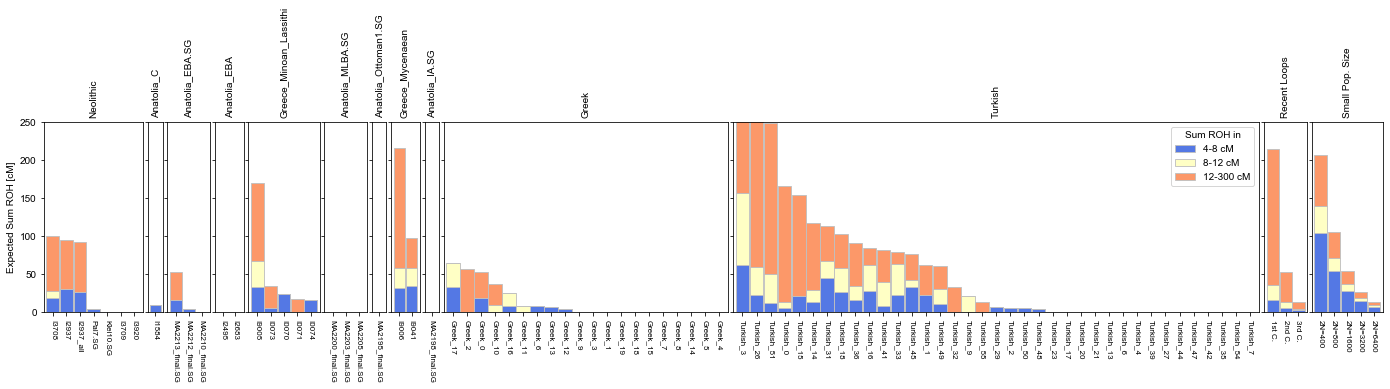

In [61]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Aegan"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

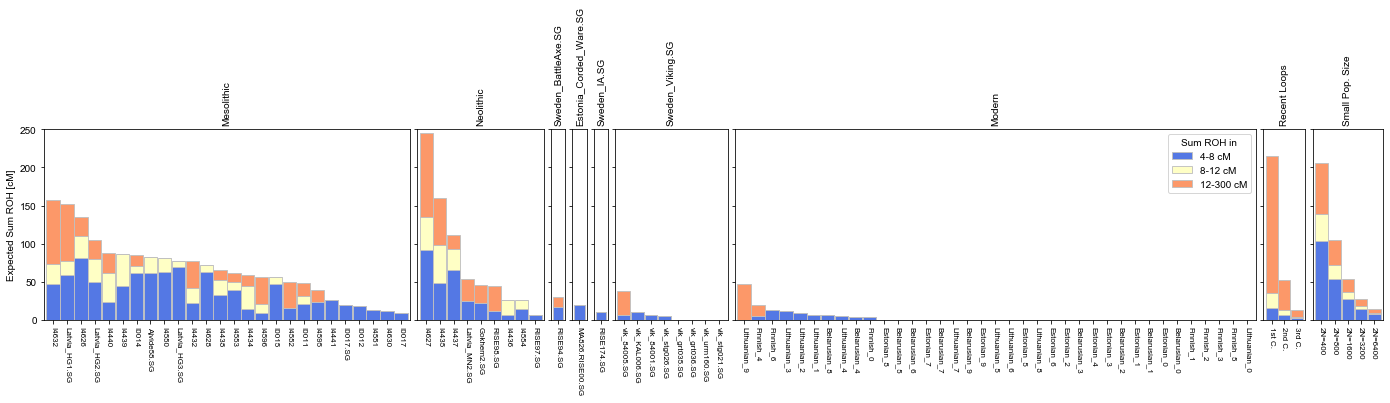

In [138]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Baltic Sea"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

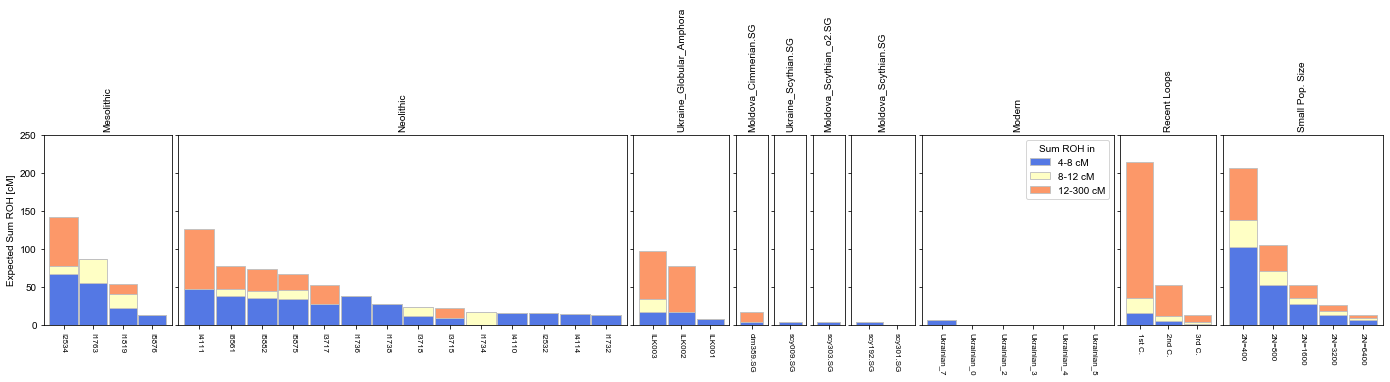

In [140]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Black Sea"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

Saved figure to ./figures_test/vanuatu_bar.pdf


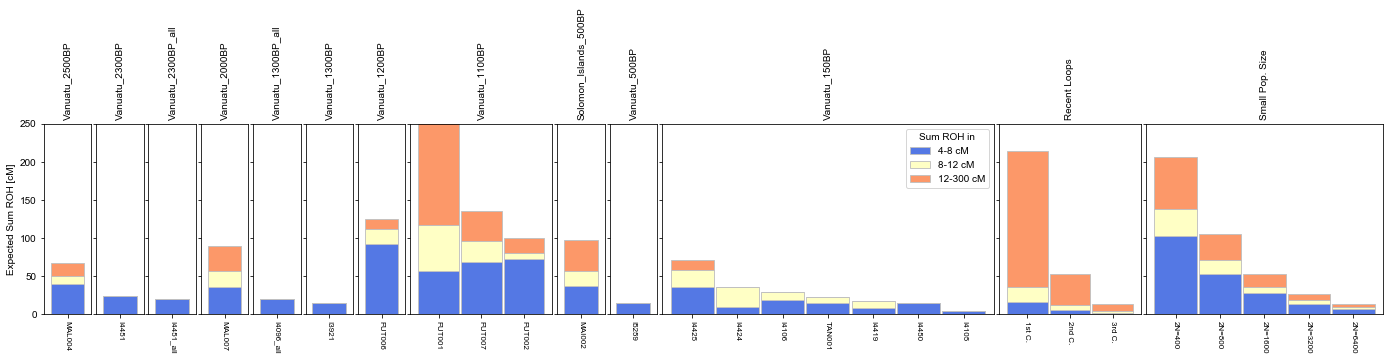

In [142]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Vanuatu"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures_test/vanuatu_bar.pdf", leg_pos=-1)

Saved figure to ./figures/levante_pilot.pdf


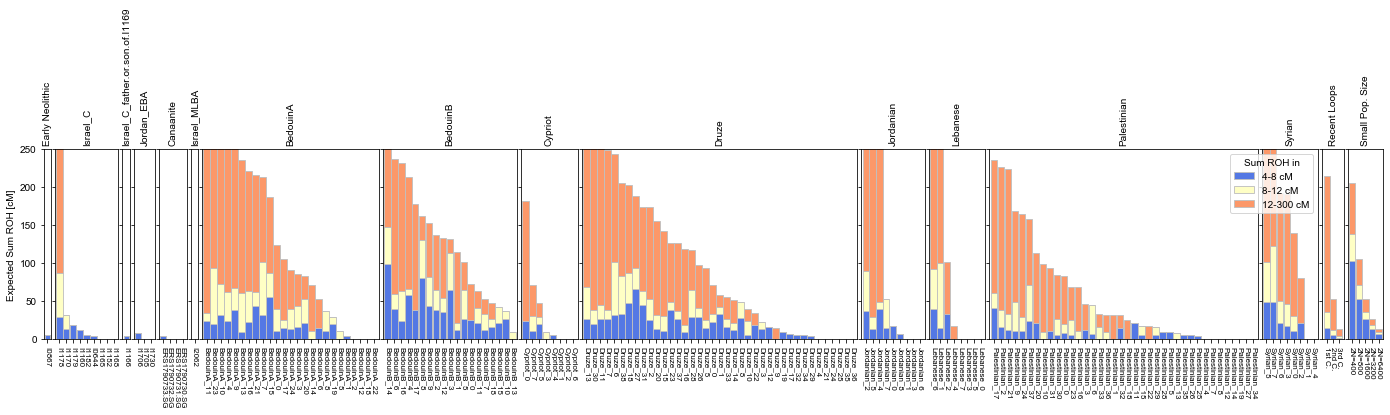

In [28]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Levante"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures/levante_pilot.pdf", leg_pos=-1, ylim=[0,250])

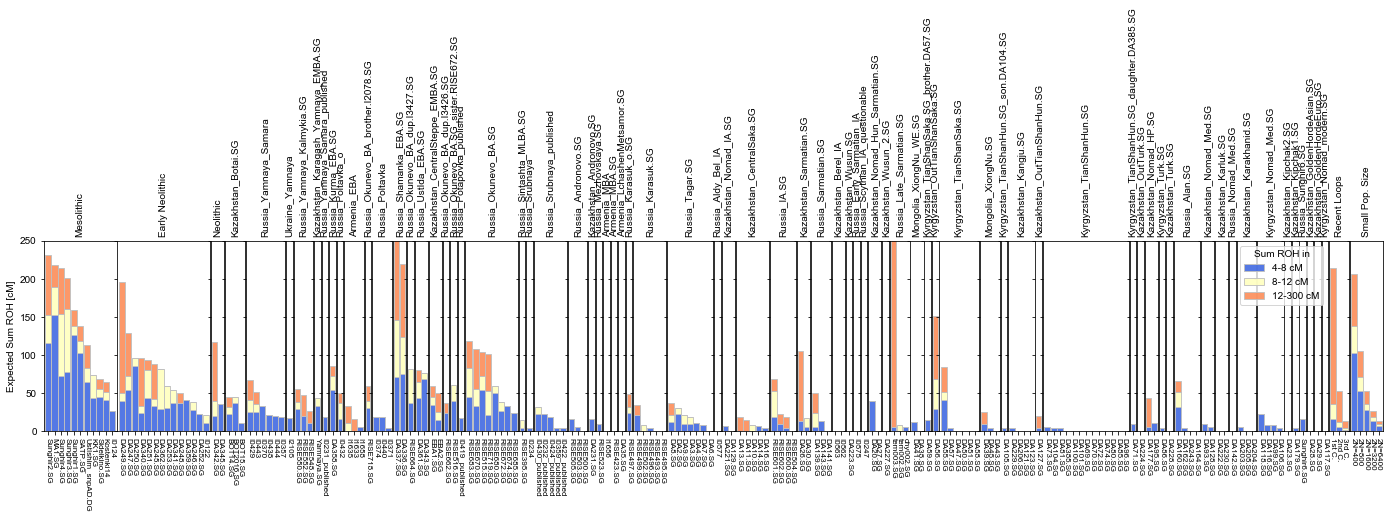

In [15]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Steppe"]
df1 = df1[df1["age"]>0] # Only Modern Samples
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

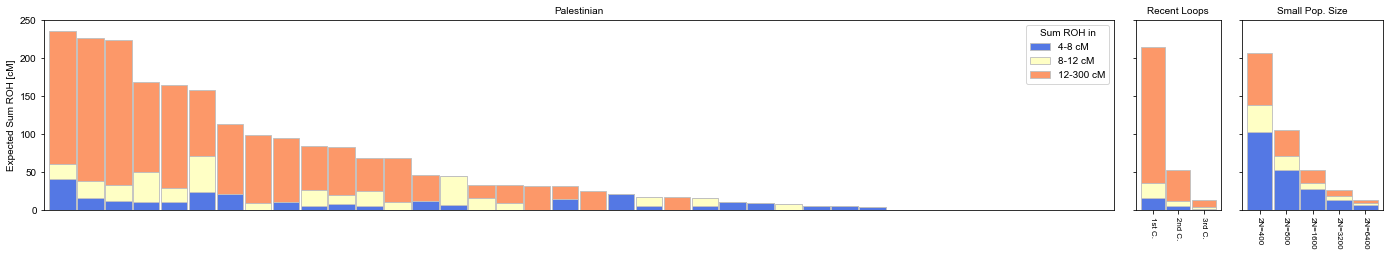

In [63]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Palestinian"]  #BedouinA Palestinian
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, x_ticks=False, r_title=0)

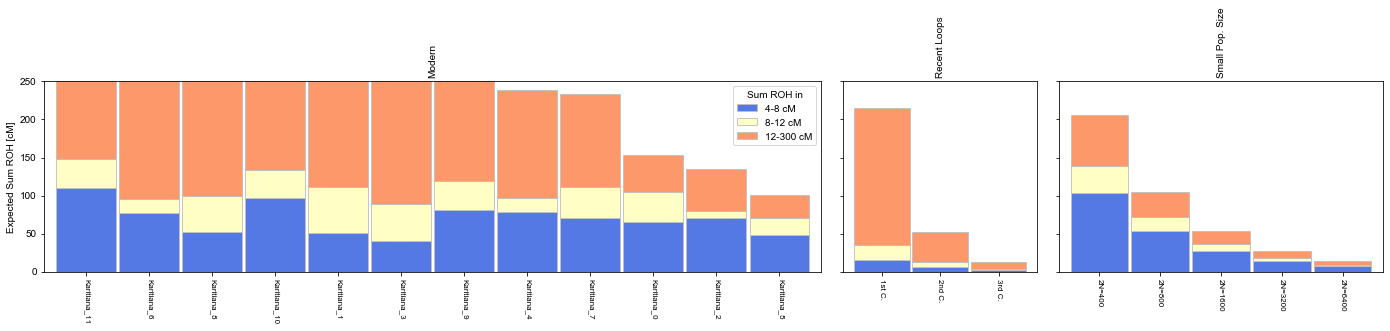

In [53]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Karitiana"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

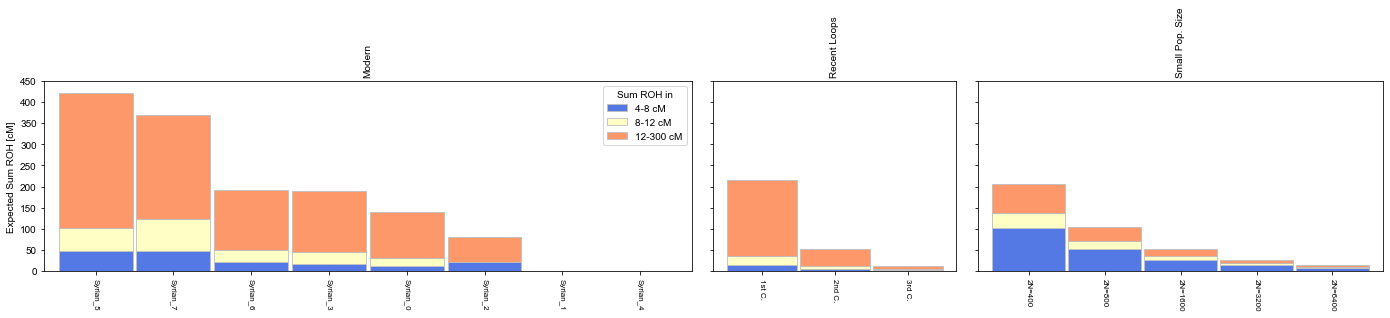

In [54]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Syrian"] # Sindhi/Saudi/Makrani
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,450])

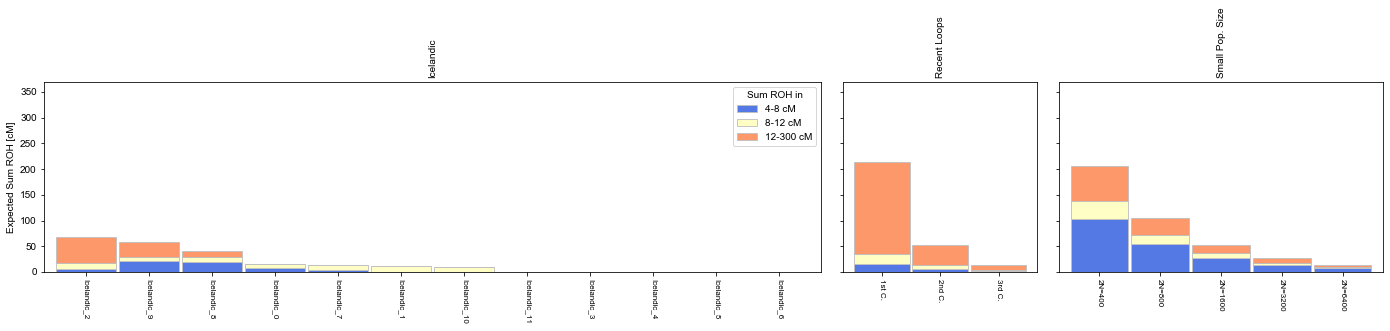

In [115]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Icelandic"] # Sindhi/Saudi/Makrani/Pathan
plot_dfs1, cols = prepare_dfs_plot(df1)
#c = ["#91bfdb", "#ffffbf", "#fc8d59"]
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,370])

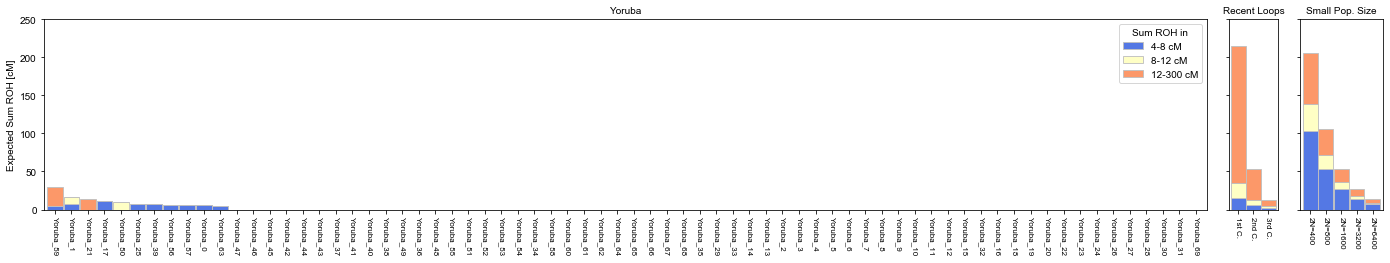

In [11]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Yoruba"] # Sindhi/Saudi/Makrani/Nganasan/Mozabite
plot_dfs1, cols = prepare_dfs_plot(df1)
#c = ["#67a9cf",  "gray", "#ef8a62"]
#c = ["#5e3c99", "#fdb863", "#e66101"]
#c = ["#91bfdb", "#ffffbf", "#fc8d59"]
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,250], r_title=0)

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1.sort_values(by="sum_roh>12", ascending=False)

### Freilich 20 Transect

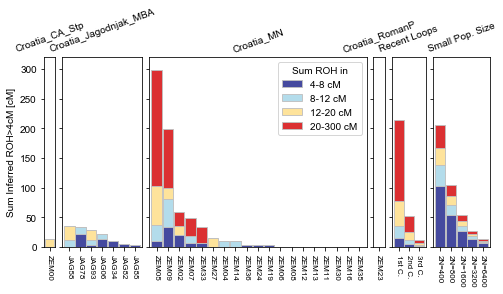

In [11]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Freilich20/combined_roh05.csv", sep='\t')
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

# ./figures_test/freilich20_bars.pdf
plot_panel_row(plot_dfs, savepath="", wspace=0.1, r_title=20, leg_pos=-2, 
               ylim=[0,320], figsize=(8,3.5))

## Sirak20 Data

Saved figure to ./figures_test/sirak_bars_41.pdf


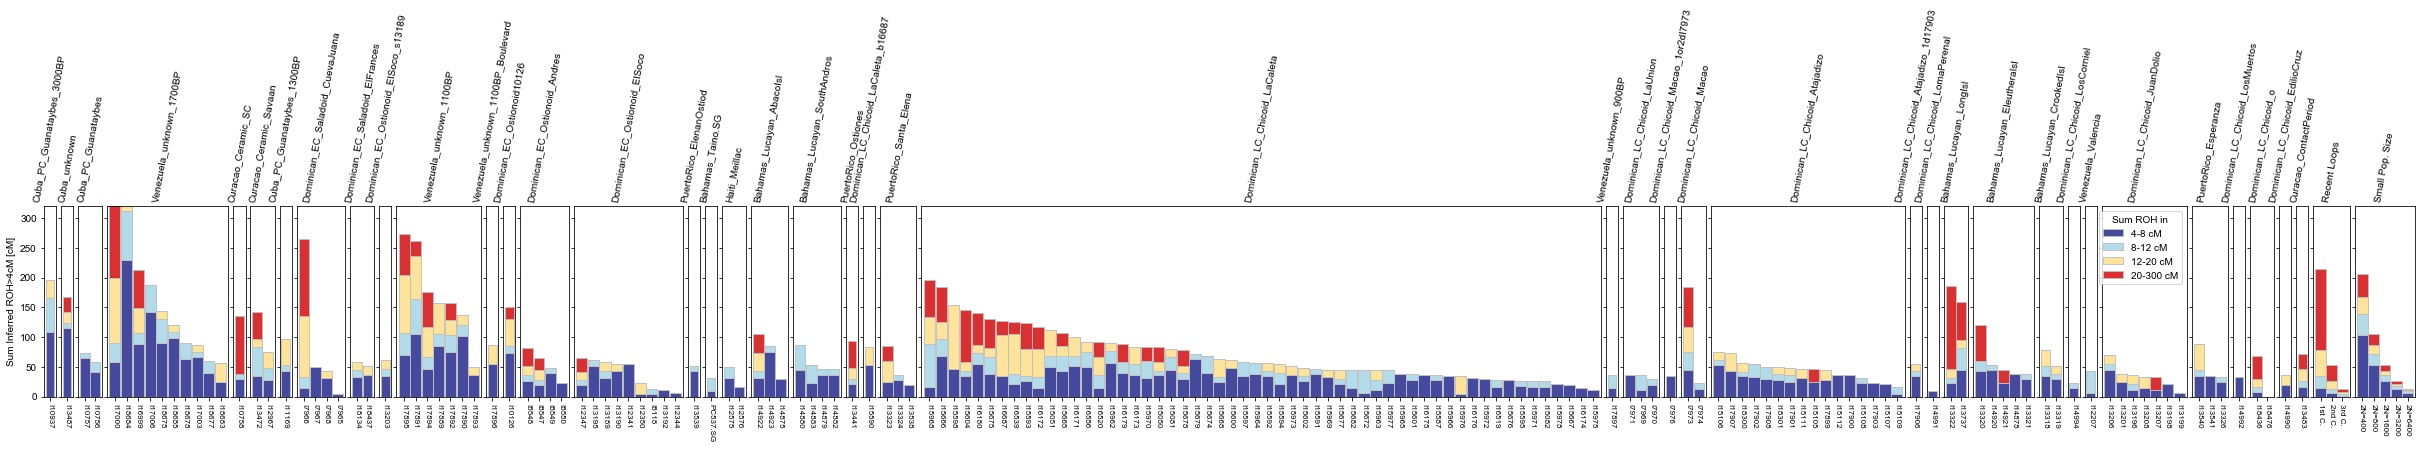

In [7]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Sirak20/combined_roh05.csv", sep='\t')
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

plot_panel_row(plot_dfs, savepath="./figures_test/sirak_bars_41.pdf", 
               wspace=0.1, r_title=80, leg_pos=-6, c=c, 
               ylim=[0,320], figsize=(len(df1)/4, 3.5))

Saved figure to ./figures_test/sirak_bars_dom.pdf


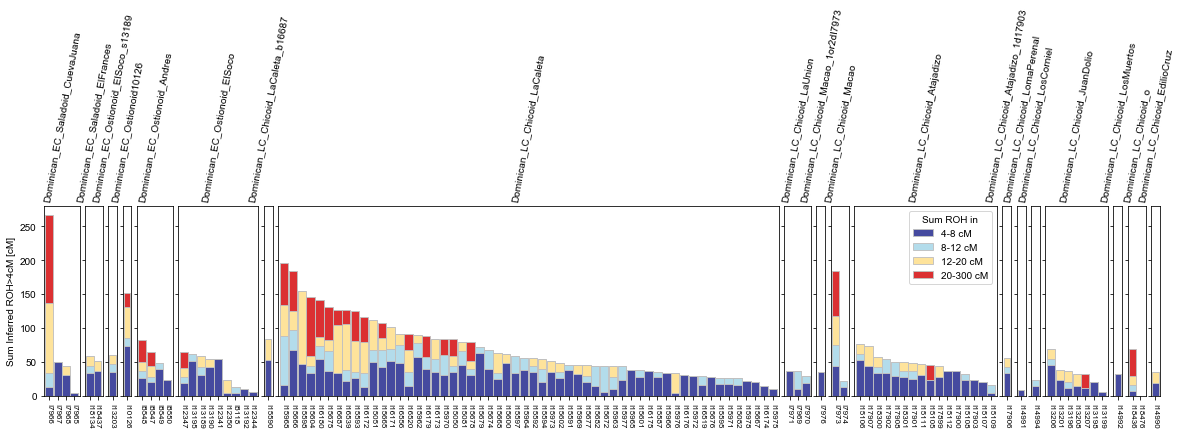

Saved figure to ./figures_test/sirak_bars_nondom.pdf


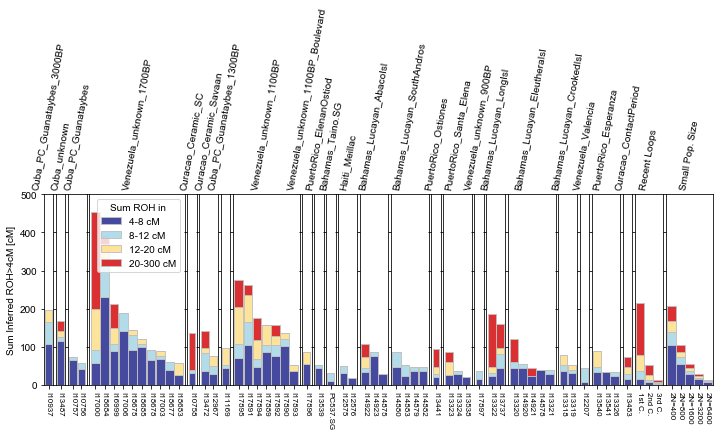

In [42]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Sirak20/combined_roh05.csv", sep='\t')
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

### Sort by Population
#pops = [df["pop"].values[0] for df in plot_dfs]
#idx = np.argsort(pops)
#plot_dfs = [plot_dfs[i] for i in idx] # Rearrange

### Pull out Dominican
#dom_idx = ["Dominican" in df["pop"].values[0] for df in plot_dfs]
plot_dfs1 = [df for df in plot_dfs if ("Dominican" in df["pop"].values[0])]
plot_dfs2 = [df for df in plot_dfs if ("Dominican" not in df["pop"].values[0])]


plot_panel_row(plot_dfs1[:], savepath="./figures_test/sirak_bars_dom.pdf", 
               wspace=0.1, r_title=80, leg_pos=-8, c=c,
               ylim=[0, 280], figsize=(20, 3.5), legends=False)

plot_panel_row(plot_dfs2[:], savepath="./figures_test/sirak_bars_nondom.pdf", 
               wspace=0.1, r_title=80, leg_pos=-20, c=c,
               ylim=[0, 500], figsize=(12, 3.5), legends=True)

       iid                         pop   age  sum_roh>20
6   I10937  Cuba_PC_Guanataybes_3000BP  3046    0.000000
13  I13487                Cuba_unknown  2050   25.732401
60  I10757         Cuba_PC_Guanataybes  2050    0.000000
36  I11169  Cuba_PC_Guanataybes_1300BP  1322    0.000000
76  I10756         Cuba_PC_Guanataybes   868    0.000000


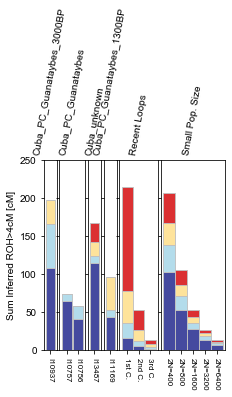

        iid                                 pop   age  sum_roh>20
0    I17000            Venezuela_unknown_1700BP  1700  253.999190
40   I18678            Venezuela_unknown_1700BP  1700    0.000000
78   I18683            Venezuela_unknown_1700BP  1700    0.000000
5    I16999            Venezuela_unknown_1700BP  1700   63.212994
8    I17006            Venezuela_unknown_1700BP  1700    0.000000
72   I18677            Venezuela_unknown_1700BP  1700    0.000000
44   I17003            Venezuela_unknown_1700BP  1700    0.000000
20   I18675            Venezuela_unknown_1700BP  1700    0.000000
1    I18684            Venezuela_unknown_1700BP  1700   23.008204
30   I18685            Venezuela_unknown_1700BP  1700    0.000000
92   I17893            Venezuela_unknown_1100BP  1100    0.000000
45   I17896  Venezuela_unknown_1100BP_Boulevard  1100    0.000000
23   I17890            Venezuela_unknown_1100BP  1100    0.000000
16   I17892            Venezuela_unknown_1100BP  1100   28.548199
15   I1788

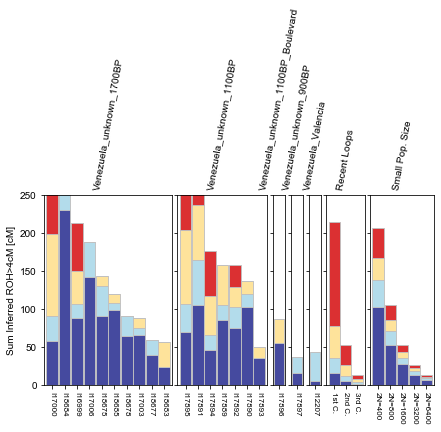

        iid                                     pop   age  sum_roh>20
96    I7967        Dominican_EC_Saladoid_CuevaJuana  1227    0.000000
168   I7965        Dominican_EC_Saladoid_CuevaJuana  1125    0.000000
3     I7966        Dominican_EC_Saladoid_CuevaJuana  1125  129.382904
74   I18134         Dominican_EC_Saladoid_ElFrances  1119    0.000000
166  I12344           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
164  I13192           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
162   I8118           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
152  I12350           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
150   I8550           Dominican_EC_Ostionoid_Andres  1100    0.000000
53    I8548           Dominican_EC_Ostionoid_Andres  1100   31.734002
83   I12341           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
82   I13190           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
75   I13189           Dominican_EC_Ostionoid_ElSoco  1100    0.000000
71   I13203    Domin

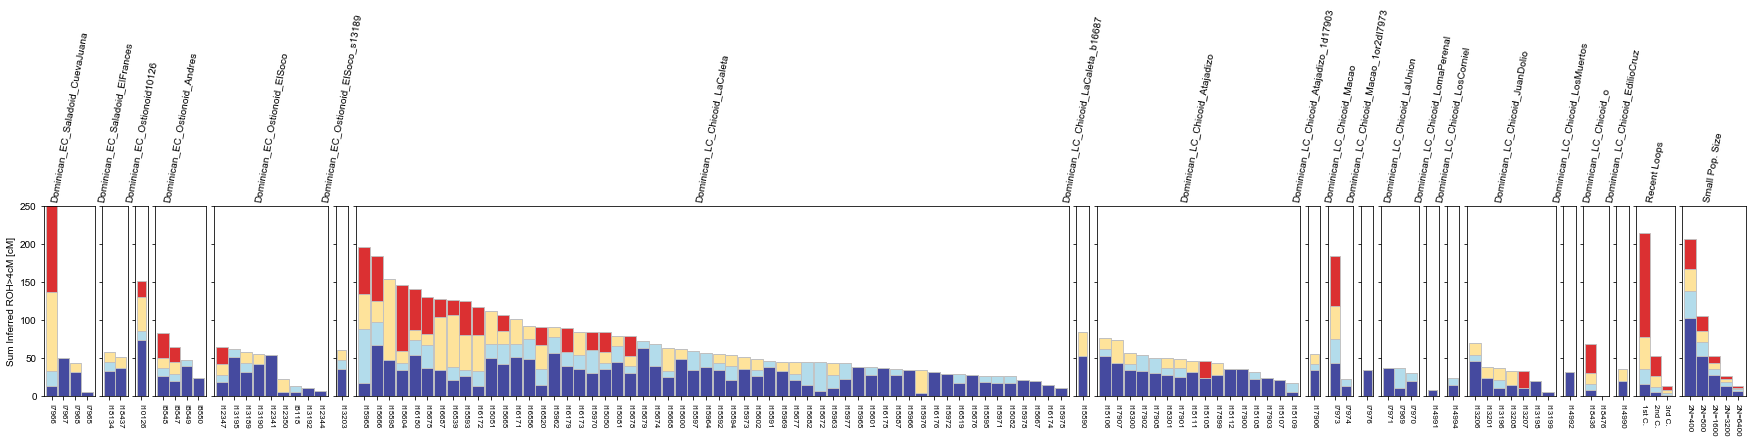

          iid                           pop   age  sum_roh>20
115    I14878  Bahamas_Lucayan_EleutheraIsl  1630    0.000000
107    I14921  Bahamas_Lucayan_EleutheraIsl  1429   22.261298
140  PC537.SG              Bahamas_Taino.SG   995    0.000000
87     I14883   Bahamas_Lucayan_SouthAndros   950    0.000000
86     I14920  Bahamas_Lucayan_EleutheraIsl   950    0.000000
142    I14875      Bahamas_Lucayan_AbacoIsl   950    0.000000
47     I14923      Bahamas_Lucayan_AbacoIsl   950    0.000000
46     I14880   Bahamas_Lucayan_SouthAndros   950    0.000000
34     I14922      Bahamas_Lucayan_AbacoIsl   950   32.404804
56     I13318    Bahamas_Lucayan_CrookedIsl   750    0.000000
14     I13737       Bahamas_Lucayan_LongIsl   750   62.912798
90     I13319    Bahamas_Lucayan_CrookedIsl   750    0.000000
118    I13321  Bahamas_Lucayan_EleutheraIsl   750    0.000000
29     I13320  Bahamas_Lucayan_EleutheraIsl   750   59.666903
9      I13322       Bahamas_Lucayan_LongIsl   750  138.977692
103    I

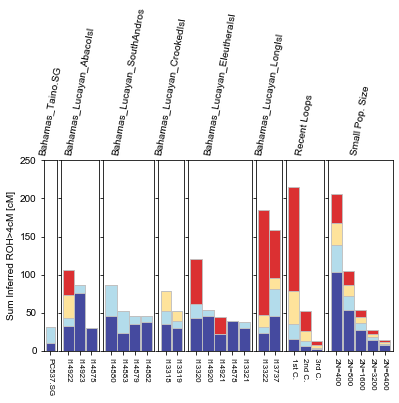

       iid                     pop   age  sum_roh>20
21  I13472  Curacao_Ceramic_Savaan  1500   44.983900
24  I10758      Curacao_Ceramic_SC  1500   96.995404
58  I12967  Curacao_Ceramic_Savaan  1500    0.000000
62  I13483   Curacao_ContactPeriod   450   25.188804


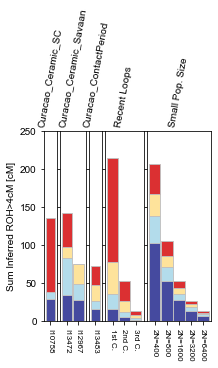

        iid                      pop   age  sum_roh>20
91   I13539  PuertoRico_ElenanOstiod  1050    0.000000
37   I13441      PuertoRico_Ostiones   950   46.867609
48   I13323   PuertoRico_Santa_Elena   900   24.132899
125  I13324   PuertoRico_Santa_Elena   900    0.000000
158  I13538   PuertoRico_Santa_Elena   900    0.000000
42   I13540     PuertoRico_Esperanza   600    0.000000
133  I13541     PuertoRico_Esperanza   600    0.000000
137  I13326     PuertoRico_Esperanza   600    0.000000


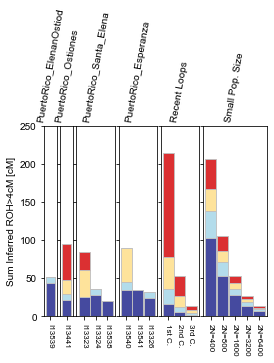

        iid            pop  age  sum_roh>20
94   I12575  Haiti_Meillac  950         0.0
160  I12576  Haiti_Meillac  950         0.0


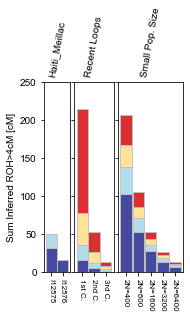

In [19]:
### Extract all for one Region
df1 = pd.read_csv("./Empirical/Eigenstrat/Sirak20/combined_roh05.csv", sep='\t')
pops = ["Cuba", "Venezuela", "Dominican", "Bahamas", "Curacao", "PuertoRico", "Haiti"]

for p in pops:
    df_t = df1[df1["pop"].str.contains(p)].copy()
    print(df_t.sort_values(by="age", ascending=False)[["iid","pop","age", "sum_roh>20"]])

    plot_dfs, cols = prepare_dfs_plot(df_t, cms=[4, 8, 12, 20])
    plot_panel_row(plot_dfs, savepath="", 
                   wspace=0.1, r_title=80, leg_pos=0, c=c, 
                   ylim=[0,250], figsize=((len(df_t)+8)/4, 3.5))

In [16]:
df1[df1["iid"]=="I10126"]

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,n_roh>20,lat,lon,age,age_range,study,clst,mean_cov,n_cov_snp,include_alt
18,I10126,Dominican_EC_Ostionoid10126,21.332901,151.651868,19,77.396893,5,66.011393,4,21.332901,1,18.440364,-69.642231,1100,800-900 CE,Sirak20,Dominican_EC_Ostionoid10126,0.630998,757198,1


## Plot Lazardis Data (11 Individuals)

Saved figure to ./figures_test/lazaridis16_bars.pdf


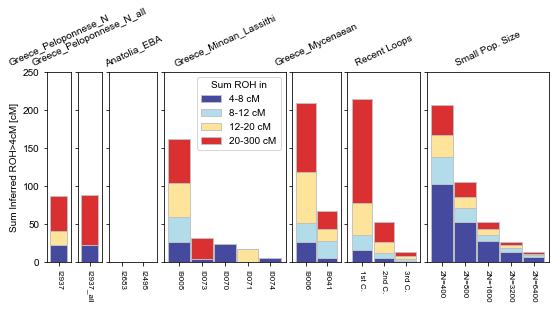

In [17]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/lazaridis11_combined_roh05.csv", sep='\t')
plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

plot_panel_row(plot_dfs, savepath="./figures_test/lazaridis16_bars.pdf", c=c,
               wspace=0.1, r_title=25, leg_pos=-2, ylim=[0,250], figsize=(9,3.5))

# Human Origins Dataset

### Plot and save every Population

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["age"]==0]  # Extract the modern samples
df1["pop"].value_counts()
pops = set(df1["pop"])

for pop in pops:
    df_t = df1[df1["pop"]==pop].copy()    # Sindhi/Saudi/Makrani/Nganasan/Mozabite
    print(f"Doing Population {pop}: {len(df_t)} Individuals")
    savepath = "./figures/ho_pops_barplots/" + str(pop) + ".pdf" 
    plot_dfs1, cols = prepare_dfs_plot(df_t, cms=[4,8,12])
    plot_panel_row(plot_dfs1, savepath=savepath, leg_pos=-1, ylim=[0,250], 
                   r_title=0, show=False)

### Do them with 4 Length Bins
An additional 20 cM Bin

In [ ]:
df1 = pd.read_csv("./Empirical/HO/CombinedROH/combined_roh05.csv", sep='\t')
#df1 = df1[df1["age"]==0]  # Extract the modern samples
df1["pop"].value_counts()
pops = list(set(df1["pop"]))

for pop in pops[:]:
    df_t = df1[df1["pop"]==pop].copy()    # Sindhi/Saudi/Makrani/Nganasan/Mozabite
    print(f"Doing Population {pop}: {len(df_t)} Individuals")
    savepath = "./figures/ho_pops_barplots/" + str(pop) + ".pdf" 
    plot_dfs1, cols = prepare_dfs_plot(df_t, cms=[4,8,12,20])
    plot_panel_row(plot_dfs1, figsize=((len(plot_dfs1[0])+8)/3, 3.5),
                   savepath=savepath, leg_pos=-1, ylim=[0,250], 
                   r_title=0, show=False, c=c)
    plt.close() # Close all open figures, otherwise PICTOCALYPE
print("Finished!")

# Make Summary Plot

In [100]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1["region"].value_counts()

Balkans           315
Central Europe    246
Britain           240
Steppe            230
Iberia            159
all               157
Rome              121
Aegan              86
Sardinia           82
Baltic Sea         74
Black Sea          30
Levante            27
Andean             25
Vanuatu            19
Pacific NW         16
Atlantic Coast     15
Patagonia           8
North Africa        5
Name: region, dtype: int64

### What to plot

## Mesoltihic Iberia, Early Neolithic, Middle Neolithic
## Italian Mesolithic, Neolithic
## Central European HG, Neolithic
## Anatolia N
## Balkan HG, Neolithic

### South America?

### HO: Examples: Pakistan, South America, Europe, Chinese


### To plot (to stay flexible):
# Give list of lists (for each row) of plot_dfs (each of them pre-processed)
# Code to plot rows

### Todo: 
- Pre-Process the data
- Write the Plotting engine

# Area 51

### Pilot to Plot multiple rows

In [20]:
def plot_panel_2d(plot_dfs, gs=0):
    """Plot 2D Panel of Bar Plots for ROH"""
    raise NotImplementedError("pls do this")

def prep_gridspecs_2d(dim_list, fig, height_ratios=[]):
    """Prepare Gridspec objects.
    Return list of list of axis to plot on. 
    dim_list: List of Dimensions [integer list] for each row)
    fig: Figure Object on where to do it
    height_ratios: Ratios of the Heights of rows"""
    if len(height_ratios)==0:
        height_ratios = [1 for _ in dim_list]
        
    gs = gridspec.GridSpec(len(dim_list), 1, height_ratios=height_ratios, figure=fig)
    
    ax_list = []
    for i,d in enumerate(dim_list):
        gss = gs[i].subgridspec(1, len(d), width_ratios=d)   # Do the width_ratios here!!
        ax_list0 = [plt.subplot(g) for g in gss] # Create Axis Objects
        ax_list.append(ax_list0)
    return ax_list, gs

In [31]:
def plot_panel_roh_bars(plot_dfs, figsize=(24,6), wspace=2.0, hspace=2.0, 
                        ylim=[0,600], r_title=90, leg_pos=-1, bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Plot a panel of ROH Bars.
    plot_all_dfs: List of dfs to plot"""
    fig = plt.figure(figsize=figsize)
    bins_cM=(np.array(bins)*100).astype("int")
    
    dim_list = [list(map(len,ls)) for ls in plot_dfs]
    ax_list, gs = prep_gridspecs_2d(dim_list, fig)

    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for j, df_row in enumerate(plot_dfs): 
        for i, df in enumerate(df_row):   
            if i==0:
                ytick=True
            else:
                ytick=False

            if i == (len(df_row) + leg_pos):
                legend=True
            else:
                legend=False

            ax = ax_list[j][i]
            obs_roh = df[cols].values
            obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
            obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
            obs_roh[:,2] = obs_roh[:,2]

            plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title,
                        x_ticks = df["iid"].values, title=df["clst"].values[0], ylim=ylim)
    plt.show()

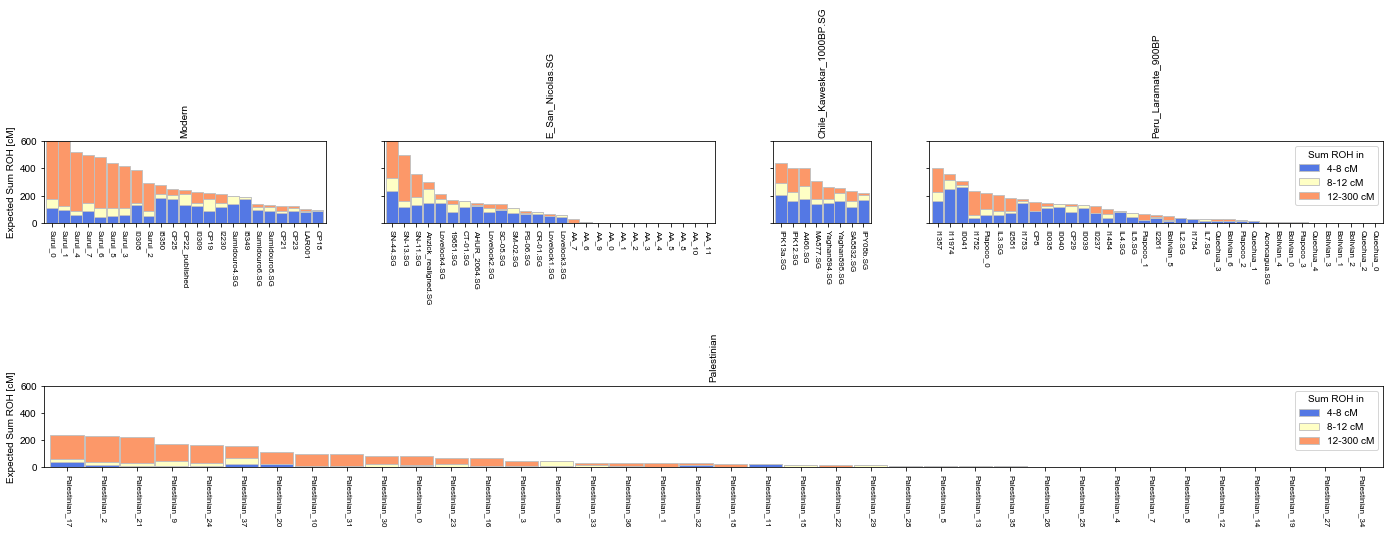

In [64]:
plot_all_dfs = [plot_dfs, plot_dfs1]
plot_panel_roh_bars(plot_all_dfs)

# Combine some interesting Pop Rows
Strategy 1: Combine Single Rows

### Do the Ancient South Americans (+ legend)

Saved figure to ./figures/barplots/sa_anc.pdf


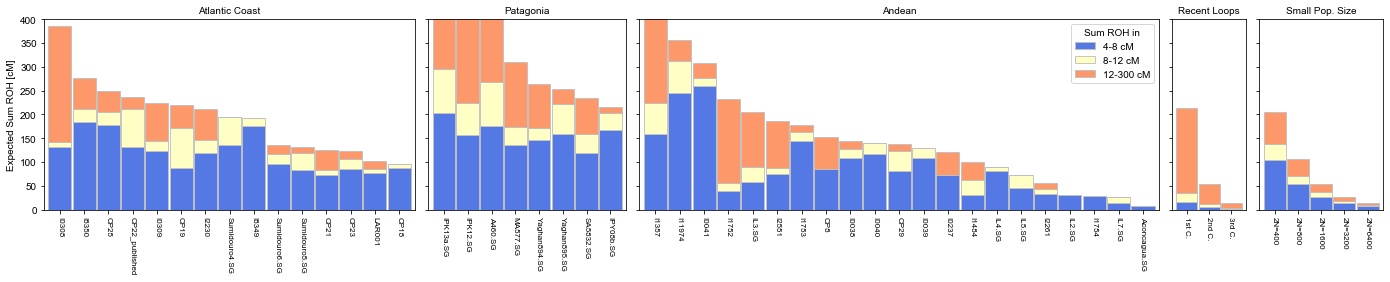

In [56]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
sa_clsts = ["Andean", "Atlantic Coast", "Patagonia"]
df_plot = df1[df1["region"].isin(sa_clsts) & df1["age"]>0].copy() # Also cut out moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,400], title_col="region", 
               leg_pos=-1, legends=True, savepath="./figures/barplots/sa_anc.pdf")

### Do key modern Populations (French, Han, Palestinian, Pathan)

Saved figure to ./figures/barplots/mod_bigpops.pdf


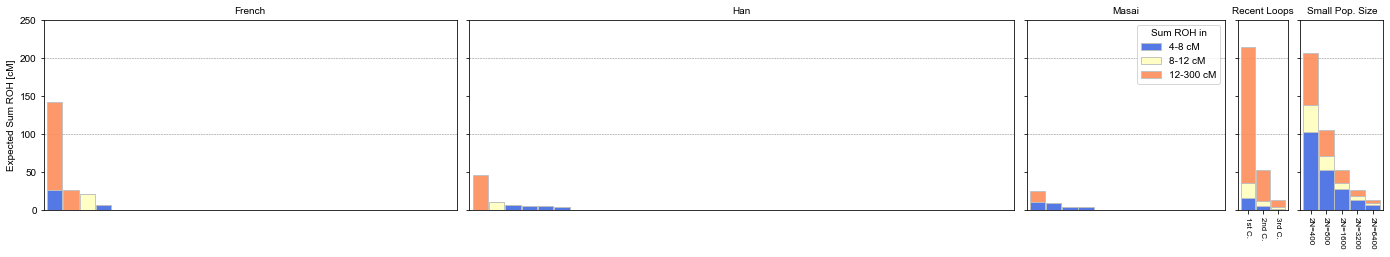

In [115]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["French", "Han", "Masai"]
df_plot = df1[(df1["pop"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,250], title_col="region", hlines=[100, 200],
               leg_pos=-1, x_ticks=False, savepath="./figures/barplots/mod_bigpops.pdf")

Saved figure to ./figures/barplots/mod_cousins.pdf


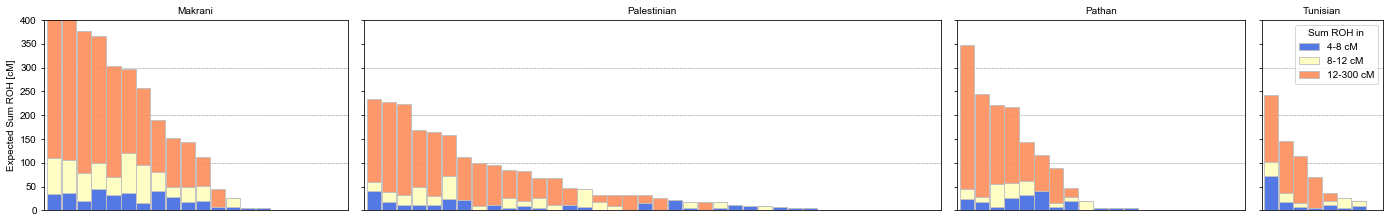

In [121]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["Palestinian", "Pathan", "Tunisian", "Makrani"]
df_plot = df1[(df1["pop"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,400], title_col="region", leg_pos=-1, hlines=[100, 200, 300],
               legends=False, x_ticks=False, savepath="./figures/barplots/mod_cousins.pdf")

Saved figure to ./figures/barplots/mod_smallpops.pdf


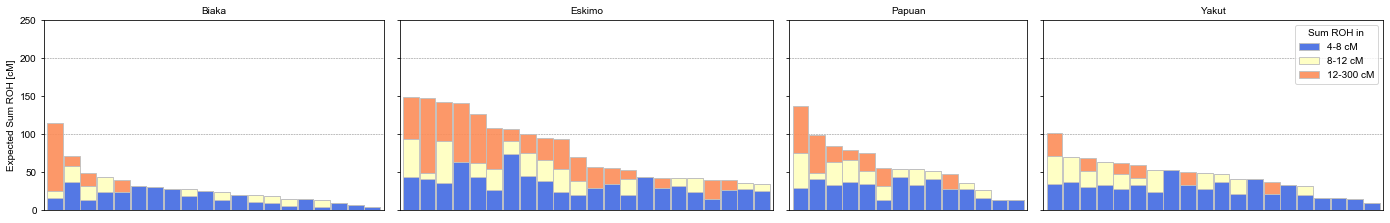

In [114]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["Biaka", "Yakut", "Eskimo", "Papuan"]
df_plot = df1[(df1["pop"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,250], title_col="region", leg_pos=-1, hlines=[100, 200],
               legends=False, x_ticks=False, savepath="./figures/barplots/mod_smallpops.pdf")

### Do key ancient Eurasian Pops
Imperial Rome, Mesolithic Steppe, Anatolia N, Iberia Mesolithic, EN, N

### Plot Mesolithic Populations

Saved figure to ./figures/barplots/anc_eu_meso.pdf


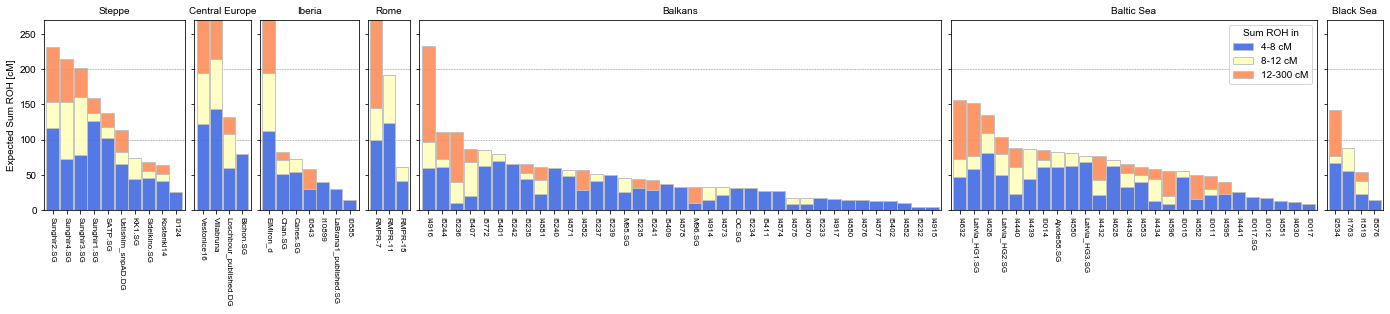

In [110]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
regions = ["Central Europe", "Balkans", "Iberia", "Black Sea", "Baltic Sea", "Steppe", "Rome"]
df_plot = df1[(df1["region"].isin(regions)) & (df1["clst"]=="Mesolithic")].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,270], title_col="region", leg_pos=-2, hlines=[100, 200], 
               legends=False, savepath="./figures/barplots/anc_eu_meso.pdf")

### Plot Neoltihic Populations

Saved figure to ./figures/barplots/anc_eu_neol.pdf


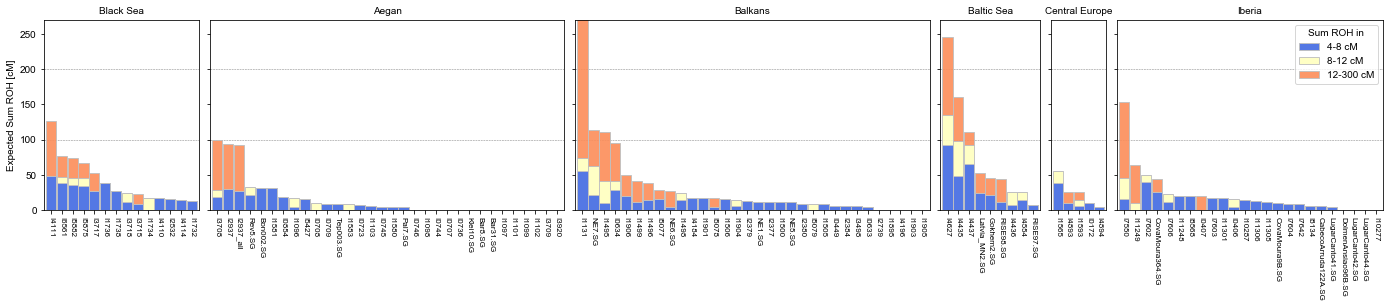

In [111]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
regions = ["Central Europe", "Balkans", "Iberia", "Black Sea", "Baltic Sea", "Steppe", "Aegan"]
df_plot = df1[(df1["region"].isin(regions)) & (df1["clst"]=="Neolithic")].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,270], title_col="region", leg_pos=-1, hlines=[100, 200],
               legends=False,  savepath="./figures/barplots/anc_eu_neol.pdf")

### Plot Yamnaya

Saved figure to ./figures/barplots/anc_yamnaya.pdf


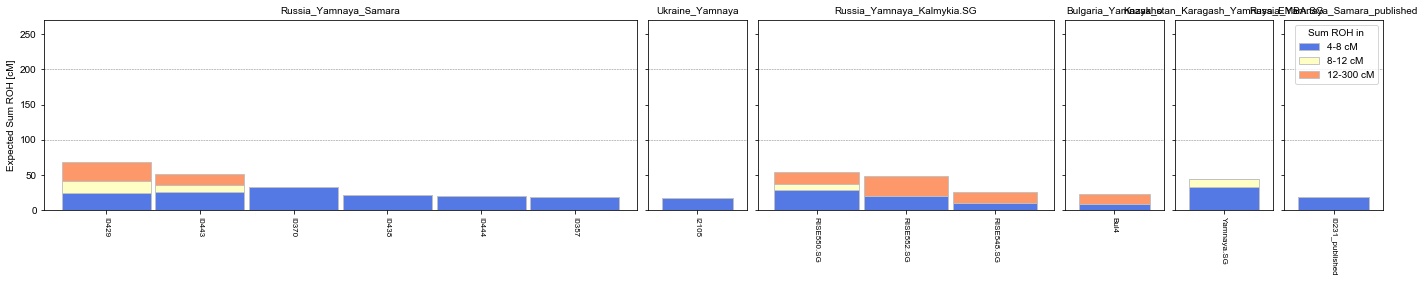

In [112]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df_plot = df1[(df1["age"]>0) & (df1["clst"].str.contains("Yamnaya"))].copy()
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="clst", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,270], title_col="clst", leg_pos=-1, hlines=[100, 200],
               legends=False,  savepath="./figures/barplots/anc_yamnaya.pdf")

## Multipanel Plot

In [54]:
#plot_panel_roh_bars([plot_dfs1, plot_dfs], ylim=[0,600], r_title=0, hspace=0.5)

### Calculate some Expectations

In [8]:
%%time
#bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 2.00]] # The original 3 bins

bins = [[0.04, 0.08], [0.08, 0.12], [0.12, 0.2], [0.2,3.0]] # 4 bis
c=["#313695", "#abd9e9", "#fee090", "#d7191c"] # Colors for 4 bins
Ns=[400, 800, 1600, 3200, 6400]
degrees=[1, 2, 3]

### Calcualte Expectations Cousins:
c_roh = create_cousins_roh(degrees = degrees, bins = bins)

### Calculate Expectations Ne:
#n_roh = create_Ne_roh(Ns=Ns, bins = bins) # Legacy so that code below works
sum_roh = create_Ne_roh(Ns=Ns, bins = bins)
std_roh = std_Ne_roh(Ns=Ns, bins = bins)


print(c_roh)
print(sum_roh)
print(std_roh)
#pirnt(std_roh**2)

#print(sum_roh[:,2] / sum_roh[:,0])

[[0.15417107 0.1989896  0.42775709 1.36425226]
 [0.0579345  0.06908513 0.13176871 0.26794258]
 [0.01947492 0.02146337 0.03640229 0.05146604]]
[[1.03261547 0.35490188 0.28789629 0.38360866]
 [0.53420341 0.18084461 0.14568993 0.19273741]
 [0.27173783 0.09128736 0.07328589 0.09660342]
 [0.13704896 0.04586206 0.03675387 0.04836057]
 [0.06882217 0.02298589 0.01840475 0.02419502]]
[[0.23960832 0.18588861 0.2101034  0.43409224]
 [0.17222816 0.13267691 0.14944211 0.30747857]
 [0.12279554 0.09425829 0.10598388 0.21760794]
 [0.08719129 0.06680774 0.07505279 0.15393856]
 [0.06178216 0.04729591 0.05310961 0.10887454]]
CPU times: user 840 ms, sys: 0 ns, total: 840 ms
Wall time: 839 ms
